In [ ]:
# ============================================
# 1. 安裝與匯入必要套件
# ============================================
print("正在安裝必要套件...")
!pip install deepface tf-keras opencv-python pandas pillow -q

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from deepface import DeepFace
import os
from datetime import timedelta
import glob

# 設定中文字體 (如果 Colab 缺字體，圖表標籤會顯示方塊，建議用英文或另外安裝字體)
# 為避免報錯，這邊圖表先以英文顯示，但 console 輸出保留中文
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ 套件安裝完成")

# 定義檔名標籤對照表 (根據您的說明)
# a: Calm/Neutral, b: Happy, c: Sad, d: Angry, e: Disgusted, f: Fearful, g: Surprised
LABEL_MAPPING = {
    'a': 'neutral',
    'b': 'happy',
    'c': 'sad',
    'd': 'angry',
    'e': 'disgust',
    'f': 'fear',
    'g': 'surprise'
}

# 定義情緒列表順序 (用於圖表固定順序)
EMOTION_LIST = ['neutral', 'happy', 'sad', 'angry', 'disgust', 'fear', 'surprise']

正在安裝必要套件...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 12.4 MB/s eta 0:00:00
25-12-07 10:17:24 - Directory /root/.deepface has been created
25-12-07 10:17:24 - Directory /root/.deepface/weights has been created
✓ 套件安裝完成


In [ ]:
# 安裝影片處理套件 MoviePy 和中文字體
!pip install moviepy==1.0.3
!apt-get install -y fonts-wqy-zenhei  # 安裝文泉驛正黑體 (解決中文亂碼)
!pip install "matplotlib<3.9"

import matplotlib.font_manager as fm
from moviepy.editor import VideoFileClip, ImageClip, CompositeVideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

# 設定中文字體
font_path = '/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc'

if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)        # 先把字型加進 fontManager
    plt.rcParams["font.family"] = "WenQuanYi Zen Hei"
    prop = fm.FontProperties(fname=font_path)
else:
    print("⚠️ 找不到中文字體，圖表文字可能會顯示為方塊。")
    prop = None
prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = prop.get_name()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-wqy-zenhei is already the newest version (0.9.45-8).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


目標80%

In [ ]:
# ---------------------------------------------------------
# 進階版任務 1：模型優化 (VGG-Face + RBF SVM + GridSearch)
# ---------------------------------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import joblib
import os
import glob
from deepface import DeepFace

# 標籤對照 (維持不變)
LABEL_MAPPING = {
    'a': 'neutral', 'b': 'happy', 'c': 'sad', 'd': 'angry',
    'e': 'disgust', 'f': 'fear', 'g': 'surprise'
}
EMOTION_ID = {k: i for i, k in enumerate(LABEL_MAPPING.values())}

def train_optimized_classifier(folder_path):
    print(f"\n{'='*80}")
    print("🚀 正在執行：進階模型訓練 (VGG-Face + RBF Kernel + 自動參數調優)")
    print(f"{'='*80}")

    if not os.path.isdir(folder_path):
        print(f"❌ 錯誤：資料夾 '{folder_path}' 不存在。")
        return None, None

    # --- 1. 特徵提取 (Feature Extraction) ---
    # 策略：改用 VGG-Face，它通常提供更豐富的情緒特徵細節
    TARGET_MODEL = "VGG-Face"
    print(f"★ 使用模型: {TARGET_MODEL} (特徵維度更高，能捕捉更多細節)")

    X = []
    y = []

    image_files = []
    for ext in ['*.jpg', '*.png', '*.jpeg']:
        image_files.extend(glob.glob(os.path.join(folder_path, ext)))

    total = len(image_files)
    print(f"發現 {total} 張圖片，開始提取特徵...")

    for idx, img_path in enumerate(image_files):
        filename = os.path.basename(img_path)
        try:
            label_char = filename[4].lower()
            emotion_label = LABEL_MAPPING.get(label_char)
            if emotion_label is None: continue

            # 提取特徵
            embedding_objs = DeepFace.represent(
                img_path=img_path,
                model_name=TARGET_MODEL,
                enforce_detection=False,
                detector_backend="opencv"
            )
            embedding = embedding_objs[0]["embedding"]

            X.append(embedding)
            y.append(EMOTION_ID[emotion_label])

        except Exception:
            pass

        if (idx + 1) % 50 == 0:
            print(f"  進度: {idx+1}/{total}...", end='\r')

    print(f"\n✅ 特徵提取完成。有效資料: {len(X)} 筆。")

    # --- 2. 資料前處理與分割 ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # --- 3. 建立訓練管線 (Pipeline) 與 網格搜索 (Grid Search) ---
    # 策略：
    # (1) StandardScaler: SVM 對數據尺度很敏感，標準化可以顯著提升效果
    # (2) SVC(kernel='rbf'): 使用非線性核函數
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(probability=True))
    ])

    # 設定要測試的參數組合
    param_grid = {
        'svm__C': [1, 10, 100, 1000],       # 懲罰係數：越大容錯率越低（越精準但易過擬合）
        'svm__gamma': [0.001, 0.0001, 'scale', 'auto'], # 核函數係數：控制影響範圍
        'svm__kernel': ['rbf']              # 鎖定使用最強的 RBF 核
    }

    print("\n🔍 開始自動尋找最佳參數 (Grid Search)... 這需要一點時間運算...")
    clf = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    clf.fit(X_train, y_train)

    print(f"★ 找到最佳參數組合: {clf.best_params_}")

    # --- 4. 最終驗證 ---
    best_model = clf.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print(f"\n{'='*80}")
    print(f"★ 優化後模型訓練完成！")
    print(f"★ 測試集準確率 (Test Accuracy): {acc*100:.2f}%")
    print(f"{'='*80}")

    print("\n[詳細分類報告]")
    print(classification_report(y_test, y_pred, target_names=LABEL_MAPPING.values()))

    # 儲存最佳模型
    joblib.dump(best_model, "custom_emotion_model_optimized.pkl")
    print("最佳模型已儲存為 'custom_emotion_model_optimized.pkl'")

    return best_model, acc

# ==========================================
# 執行優化版任務 1
# ==========================================
DATASET_PATH = '/content/drive/MyDrive/NTU/114-1/Psychoinformatics/faces_256x256'

if os.path.exists(DATASET_PATH):
    custom_model, accuracy = train_optimized_classifier(DATASET_PATH)
else:
    print(f"⚠️ 找不到路徑: {DATASET_PATH}")


🚀 正在執行：進階模型訓練 (VGG-Face + RBF Kernel + 自動參數調優)
★ 使用模型: VGG-Face (特徵維度更高，能捕捉更多細節)
發現 1232 張圖片，開始提取特徵...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5


25-12-07 10:22:00 - 🔗 vgg_face_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5 to /root/.deepface/weights/vgg_face_weights.h5...


100%|██████████| 580M/580M [00:04<00:00, 118MB/s]



✅ 特徵提取完成。有效資料: 1223 筆。

🔍 開始自動尋找最佳參數 (Grid Search)... 這需要一點時間運算...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
★ 找到最佳參數組合: {'svm__C': 100, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}

★ 優化後模型訓練完成！
★ 測試集準確率 (Test Accuracy): 82.45%

[詳細分類報告]
              precision    recall  f1-score   support

     neutral       0.81      0.89      0.85        19
       happy       0.98      0.93      0.95        56
         sad       0.93      0.84      0.88        31
       angry       0.78      0.81      0.79        36
     disgust       0.67      0.84      0.74        38
        fear       0.63      0.68      0.65        25
    surprise       0.94      0.72      0.82        40

    accuracy                           0.82       245
   macro avg       0.82      0.82      0.81       245
weighted avg       0.84      0.82      0.83       245

最佳模型已儲存為 'custom_emotion_model_optimized.pkl'


In [ ]:
# ==============================================================================
# 任務 2 & 3：使用優化後的客製化模型 (VGG-Face + SVM) 分析影片
# ==============================================================================
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os
from deepface import DeepFace

# 1. 載入您剛剛訓練好的最佳模型
MODEL_PATH = "custom_emotion_model_optimized.pkl"
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"找不到模型檔案：{MODEL_PATH}，請確認您已執行過訓練步驟。")

print(f"正在載入客製化模型：{MODEL_PATH} ...")
clf_model = joblib.load(MODEL_PATH)
print("模型載入成功！")

# 2. 重建標籤對照表 (必須與訓練時完全一致)
LABEL_MAPPING = {
    'a': 'neutral', 'b': 'happy', 'c': 'sad', 'd': 'angry',
    'e': 'disgust', 'f': 'fear', 'g': 'surprise'
}
# 建立 ID 轉文字的對照 (因為模型預測出來的是 0, 1, 2... 數字)
EMOTION_ID = {k: i for i, k in enumerate(LABEL_MAPPING.values())}
ID_TO_EMOTION = {v: k for k, v in EMOTION_ID.items()}
EMOTION_LIST = list(LABEL_MAPPING.values()) # ['neutral', 'happy', ...] 用於圖表順序

# -----------------------------------------------------------
# 核心預測函數：輸入圖片，輸出客製化模型的預測結果
# -----------------------------------------------------------
def predict_emotion_custom(img_array):
    """
    使用 VGG-Face 提取特徵，再用 SVM 預測情緒
    """
    try:
        # 1. 提取特徵 (Feature Extraction) - 重要：必須使用跟訓練時一樣的設定
        embedding_objs = DeepFace.represent(
            img_path=img_array,
            model_name="VGG-Face",        # 必須與訓練時相同
            enforce_detection=False,      # 找不到臉時不報錯
            detector_backend="opencv"     # 必須與訓練時相同
        )
        embedding = embedding_objs[0]["embedding"]

        # 2. 使用 SVM 模型預測 (Prediction)
        # predict_proba 會回傳每個情緒的機率 [0.1, 0.8, 0.05...]
        probs = clf_model.predict_proba([embedding])[0]
        pred_id = clf_model.predict([embedding])[0]

        pred_label = ID_TO_EMOTION[pred_id]

        # 將結果整理成字典回傳
        result = {'dominant_emotion': pred_label}
        for idx, prob in enumerate(probs):
            # scikit-learn 的 classes_ 順序對應機率
            emotion_name = ID_TO_EMOTION[clf_model.classes_[idx]]
            result[emotion_name] = prob * 100 # 轉成百分比

        return result

    except Exception as e:
        # 如果發生錯誤 (例如完全沒畫面)，回傳空值
        return None

# -----------------------------------------------------------
# 影片分析主程式 (整合了每秒分析與連續分析)
# -----------------------------------------------------------
def analyze_video_with_custom_model(video_path, mode='per_second'):
    """
    Args:
        video_path: 影片路徑
        mode: 'per_second' (每秒分析一次) 或 'continuous' (連續分析，每5幀一次)
    """
    if not os.path.exists(video_path):
        print(f"❌ 找不到影片：{video_path}")
        return

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    # 設定取樣頻率
    if mode == 'per_second':
        step = fps  # 每秒取一張
        output_csv = 'custom_model_video_per_second.csv'
        print(f"\n[模式：每秒分析] 影片時長: {duration:.1f}秒")
    else:
        step = 5    # 連續模式 (每5幀取一張，確保畫圖平滑且速度適中)
        output_csv = 'custom_model_video_continuous.csv'
        print(f"\n[模式：連續分析] 影片時長: {duration:.1f}秒 (取樣間隔: 每{step}幀)")

    results = []
    frame_idx = 0

    print("開始分析影片 (使用 VGG-Face + SVM 高準確率模型)...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break

        if frame_idx % step == 0:
            # 進行預測
            analysis_result = predict_emotion_custom(frame)

            if analysis_result:
                timestamp = frame_idx / fps
                row = {
                    'frame': frame_idx,
                    'timestamp': timestamp,
                    'dominant_emotion': analysis_result['dominant_emotion']
                }
                # 加入各情緒機率
                for emo in EMOTION_LIST:
                    row[emo] = analysis_result.get(emo, 0)

                results.append(row)

                # 顯示進度
                print(f"已處理: {timestamp:.1f} / {duration:.1f} 秒...", end='\r')

        frame_idx += 1

    cap.release()
    print(f"\n✅ 分析完成！數據已儲存至: {output_csv}")

    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False, encoding='utf-8-sig')

    # 如果是連續模式，直接畫圖
    if mode == 'continuous' and not df.empty:
        draw_chart(df)

    return df

def draw_chart(df):
    """畫出精美的折線圖"""
    print("\n正在繪製情緒趨勢圖...")
    plt.figure(figsize=(14, 7))

    # 設定顏色 (可依喜好調整)
    colors = {
        'neutral': '#808080', 'happy': '#FFD700', 'sad': '#1E90FF',
        'angry': '#FF4500', 'disgust': '#32CD32', 'fear': '#800080', 'surprise': '#00CED1'
    }

    for emo in EMOTION_LIST:
        if emo in df.columns:
            plt.plot(df['timestamp'], df[emo], label=emo, color=colors.get(emo), linewidth=2, alpha=0.8)

    plt.title('Emotion Timeline (Custom VGG-Face Model)', fontsize=15)
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel('Probability (%)', fontsize=12)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig('custom_model_timeline.png')
    plt.show()
    print("圖表已儲存為 custom_model_timeline.png")



正在載入客製化模型：custom_emotion_model_optimized.pkl ...
模型載入成功！


Vlog 每秒情緒分析折線圖

In [ ]:
# ==========================================
# 執行分析
# ==========================================
# 確保影片檔名正確
VIDEO_FILE = '/content/drive/MyDrive/NTU/114-1/Psychoinformatics/vlog.mp4'
df_sec = analyze_video_with_custom_model(VIDEO_FILE, mode='per_second')


[模式：每秒分析] 影片時長: 39.3秒
開始分析影片 (使用 VGG-Face + SVM 高準確率模型)...
已處理: 39.0 / 39.3 秒...
✅ 分析完成！數據已儲存至: custom_model_video_per_second.csv



正在繪製情緒趨勢圖...


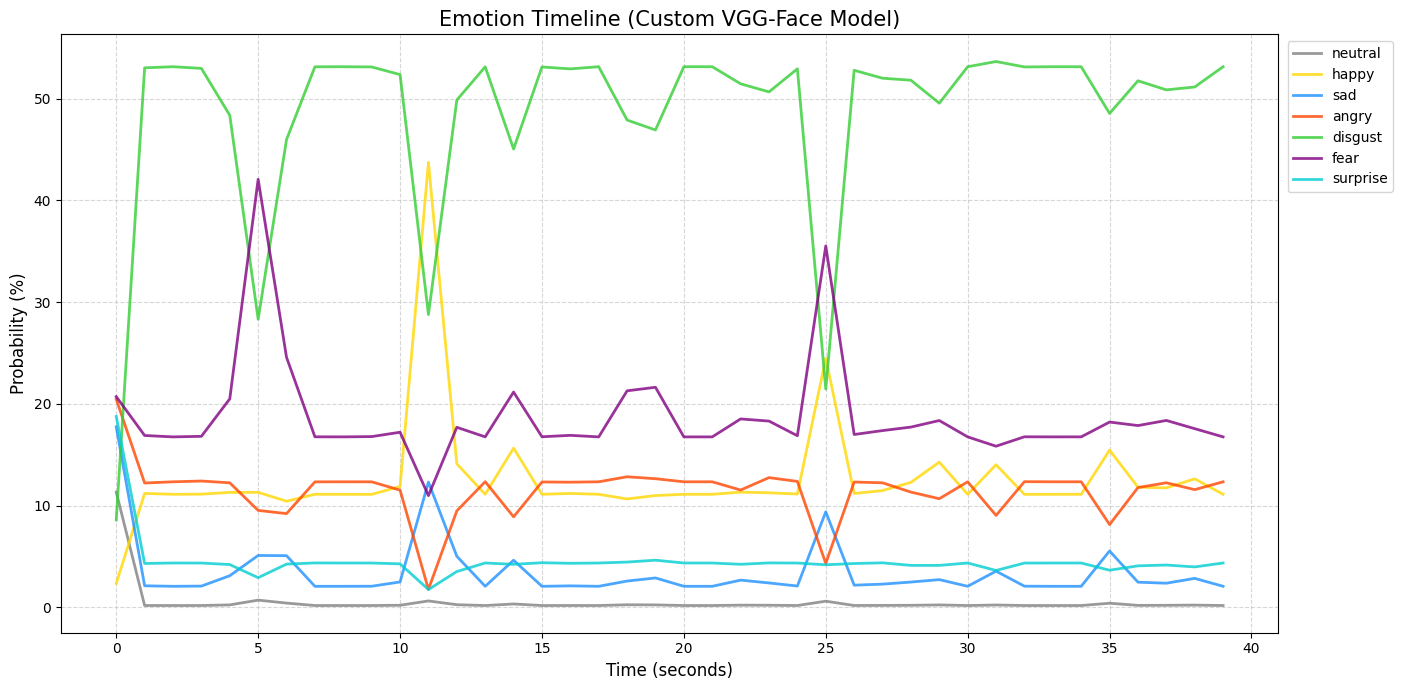

圖表已儲存為 custom_model_timeline.png


In [ ]:
draw_chart(df_sec)

Vlog 逐幀情緒分析折線圖


[模式：連續分析] 影片時長: 39.3秒 (取樣間隔: 每5幀)
開始分析影片 (使用 VGG-Face + SVM 高準確率模型)...
已處理: 39.1 / 39.3 秒...
✅ 分析完成！數據已儲存至: custom_model_video_continuous.csv

正在繪製情緒趨勢圖...


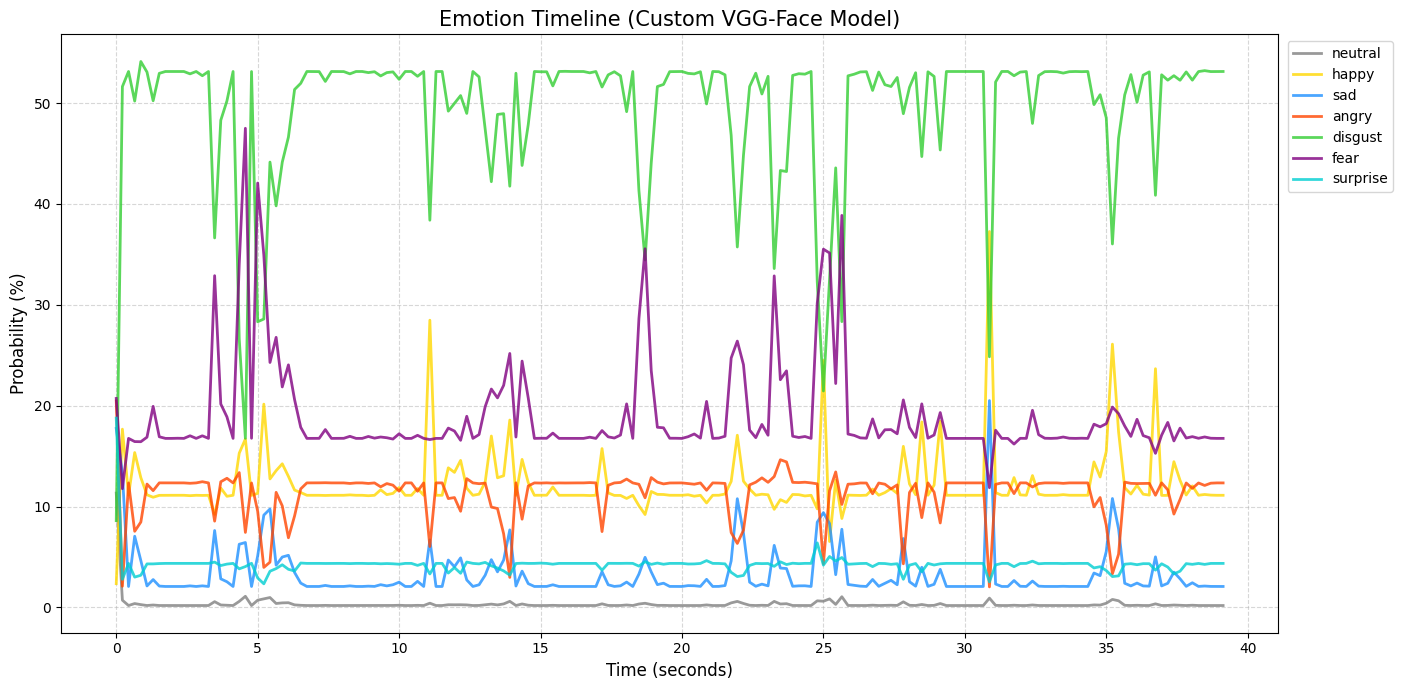

圖表已儲存為 custom_model_timeline.png


In [ ]:
df_cont = analyze_video_with_custom_model(VIDEO_FILE, mode='continuous')

In [28]:
# -----------------------------------------------------------
# 影片合成修正版 (確保 VideoClip 已正確匯入)
# -----------------------------------------------------------
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from moviepy.editor import VideoFileClip, VideoClip, clips_array
from moviepy.video.io.bindings import mplfig_to_npimage
from matplotlib.backends.backend_agg import FigureCanvasAgg

if not hasattr(FigureCanvasAgg, "tostring_rgb"):
    def tostring_rgb(self):
        # 先畫圖
        self.draw()
        # 取得寬高（w, h）
        w, h = self.get_width_height()
        # buffer_rgba 回傳 RGBA，先轉成 numpy
        buf = np.asarray(self.buffer_rgba(), dtype=np.uint8)
        # reshape 成 (h, w, 4)
        buf = buf.reshape(h, w, 4)
        # 丟掉 alpha，只保留 RGB
        rgb = buf[..., :3]
        # 轉回 bytes，讓 moviepy 用 3 channel 去 reshape
        return rgb.tobytes()

    FigureCanvasAgg.tostring_rgb = tostring_rgb

# 設定中文字體 (如果前面有安裝過 fonts-wqy-zenhei)
font_path = "/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc"

if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)        # 先把字型加進 fontManager
    plt.rcParams["font.family"] = "WenQuanYi Zen Hei"
    prop = fm.FontProperties(fname=font_path)
else:
    print("⚠️ 找不到中文字體，圖表文字可能會顯示為方塊。")
    prop = None

def create_dashboard_video(video_path, csv_path, output_path='final_output.mp4'):
    # 1. 讀取資料
    if not os.path.exists(csv_path) or not os.path.exists(video_path):
        print("❌ 找不到 CSV 或影片檔案，請確認路徑。")
        return

    df = pd.read_csv(csv_path)

    emotions = ['neutral', 'happy', 'sad', 'angry', 'disgust', 'fear', 'surprise']

    colors = {
        'neutral': '#808080', 'happy': '#FFD700', 'sad': '#1E90FF',
        'angry': '#FF4500', 'disgust': '#32CD32', 'fear': '#800080', 'surprise': '#00CED1'
    }

    LABELS_ZH = {
        'neutral': '中性', 'happy': '開心', 'sad': '悲傷', 'angry': '生氣',
        'disgust': '厭惡', 'fear': '恐懼', 'surprise': '驚訝'
    }

    # 2. 設定 Matplotlib 圖表初始化
    fig, ax = plt.subplots(figsize=(10, 4), dpi=100)

    for emo in emotions:
        if emo in df.columns:
            # 如果沒有中文字體，回退到英文標籤避免亂碼
            label = LABELS_ZH.get(emo, emo) if prop else emo
            ax.plot(df['timestamp'], df[emo], label=label,
                    color=colors.get(emo), alpha=0.6, linewidth=1.5)

    ax.set_xlim(0, df['timestamp'].max())
    ax.set_ylim(0, 105)

    # 字體設定
    title_font = prop if prop else None
    ax.set_xlabel('時間 (秒)', fontproperties=title_font)
    ax.set_ylabel('機率 (%)', fontproperties=title_font)
    ax.set_title('情緒變化分析', fontproperties=title_font, fontsize=14)
    ax.legend(loc='upper right', prop=title_font, fontsize=8, ncol=2)
    ax.grid(True, linestyle='--', alpha=0.3)

    line = ax.axvline(x=0, color='red', linewidth=2, alpha=0.8)
    text_box = ax.text(0, 110, "", fontsize=12, fontproperties=title_font,
                       color='white', backgroundcolor='black',
                       verticalalignment='bottom')

    # 3. 定義每一幀的生成函數
    def make_frame(t):
        # 限制 t 不超過資料最大時間
        t_safe = min(t, df['timestamp'].max())

        # A. 更新圖表上的時間線
        line.set_xdata([t_safe])

        # B. 取得當前時間點最接近的數據
        closest_idx = (df['timestamp'] - t_safe).abs().idxmin()
        row = df.iloc[closest_idx]

        # C. 找出最大機率的情緒
        dominant_emo = row['dominant_emotion']
        prob = row[dominant_emo]

        # 更新文字
        emo_text = LABELS_ZH.get(dominant_emo, dominant_emo) if prop else dominant_emo
        label_text = f" {t_safe:.1f}s | {emo_text} {prob:.0f}% "

        text_x = t_safe
        if t_safe > df['timestamp'].max() * 0.7:
            text_box.set_horizontalalignment('right')
            text_x = t_safe - 0.5
        else:
            text_box.set_horizontalalignment('left')
            text_x = t_safe + 0.5

        text_box.set_position((text_x, 80))
        text_box.set_text(label_text)
        text_box.set_backgroundcolor(colors.get(dominant_emo, 'black'))

        # 🔧 這裡不用 mplfig_to_npimage，直接自己轉 numpy image
        fig.canvas.draw()  # 先把目前這一幀畫好
        w, h = fig.canvas.get_width_height()
        buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = buf.reshape(h, w, 4)[..., :3]   # 丟掉 alpha，只留 RGB

        return img

    # 4. 開始影片合成
    print("正在處理影片合成，請稍候...")

    original_clip = VideoFileClip(video_path)

    # 修正點：直接使用已匯入的 VideoClip
    chart_clip = VideoClip(make_frame, duration=original_clip.duration)

    h = original_clip.h
    # 避免高度為奇數導致編碼錯誤
    if h % 2 != 0:
        h -= 1

    # 讓折線圖高度跟影片一樣
    chart_clip = chart_clip.resize(height=h)

    # 水平堆疊：左邊影片、右邊折線圖
    final_clip = clips_array([[original_clip, chart_clip]])

    # 寫入檔案
    final_clip.write_videofile(output_path, fps=24, codec='libx264', audio_codec='aac')

    plt.close()
    print(f"\n✅ 影片製作完成！已儲存為: {output_path}")
    return output_path

# ==========================================
# 執行合成
# ==========================================
VIDEO_FILE = '/content/drive/MyDrive/NTU/114-1/Psychoinformatics/vlog.mp4'
CSV_FILE = 'custom_model_video_continuous.csv'
OUTPUT_FILE = 'emotion_dashboard.mp4'

if os.path.exists(VIDEO_FILE) and os.path.exists(CSV_FILE):
    create_dashboard_video(VIDEO_FILE, CSV_FILE, OUTPUT_FILE)
else:
    print(f"找不到檔案！\n影片: {os.path.exists(VIDEO_FILE)}\nCSV: {os.path.exists(CSV_FILE)}")

正在處理影片合成，請稍候...
Moviepy - Building video emotion_dashboard.mp4.
MoviePy - Writing audio in emotion_dashboardTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video emotion_dashboard.mp4



Moviepy - Done !
Moviepy - video ready emotion_dashboard.mp4

✅ 影片製作完成！已儲存為: emotion_dashboard.mp4


In [29]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):
    if not os.path.exists(video_path):
        print("影片檔案不存在")
        return

    mp4 = open(video_path,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f"""
    <video width=600 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """)

# 播放剛剛生成的影片
show_video('emotion_dashboard.mp4')